In [1]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

from spec_bin import *
#from lanczos_bin import mystep,distribution

from IPython.display import clear_output
np.set_printoptions(linewidth=300)
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
def model_problem_spectrum(n,rho,kappa=1e3,dtype='float'):
    '''
    returns spectrum of model problem
    '''
    lambda1 = 1/kappa
    lambdan = 1
    Lambda = lambda1+(lambdan-lambda1)*np.arange(n)/(n-1)*rho**np.arange(n-1,-1,-1,dtype=dtype)
    
    return Lambda

In [4]:
expr1 = {
    'lam': model_problem_spectrum(300,.85,1e3),
    'k_max': 100,
    'k_skip': 2,
    'd':500,
    'f': lambda x: 1/x
}

lam2 = np.load('matrices/California_eigs.npy').flatten()
lam2 /= np.max(np.abs(lam2))

expr2 = {
    'lam': lam2,
    'k_max': 600,
    'k_skip': 10,
    'd':2000,
    'f': lambda x: np.abs(x)
}

exprs = [expr1,expr2]

GQ_err = []
GQro_err = []
IQ_err = []
AQ_err = []
HQ_err = []
    
for expr_idx,expr in enumerate(exprs):
    
    lam = expr['lam']
    k_max = expr['k_max']
    k_skip = expr['k_skip']
    d = expr['d']

    n = len(lam)
    a,b = min(lam),max(lam)
    
    A = sp.sparse.spdiags(lam,0,n,n)

    v = np.ones(n)
    v/=np.linalg.norm(v)

    f = expr['f']

    
    GQ_err.append(np.full(k_max,np.nan))
    GQro_err.append(np.full(k_max,np.nan))
    IQ_err.append(np.full(k_max,np.nan))
    AQ_err.append(np.full(k_max,np.nan))
    HQ_err.append(np.full(k_max,np.nan))
    
    (α,β) = lanczos(A,v,k_max)
    (αro,βro) = lanczos_reorth(A,v,min(k_max,n),reorth=True)

    print(np.max(np.abs(α[:min(k_max,n)]-αro)),np.max(np.abs(αro)),\
          np.max(np.abs(β[:min(k_max,n)]-βro)),np.max(np.abs(βro)))

    αT = np.ones(max(2*k_max,d))*(a+b)/2
    βT = np.ones(max(2*k_max,d))*(b-a)/4
    βT[0] *= np.sqrt(2)
    m = get_chebyshev_moments(A,v,k_max,a,b)
    m_lan = get_moments_from_lanczos(A,v,2*k_max,αT,βT,T=(α,β))
    
    print(np.max(np.abs((m-m_lan))),sp.sparse.linalg.norm(A))
    
    GQ_err[-1][0] = v.T@(f(lam)*v)
    GQro_err[-1][0] = v.T@(f(lam)*v)
    IQ_err[-1][0] = v.T@(f(lam)*v)
    AQ_err[-1][0] = v.T@(f(lam)*v)
    for k in range(k_skip,k_max,k_skip):
        θ,ω = get_gq(k,α,β)
        GQ_err[-1][k] = ω@f(θ) - v.T@(f(lam)*v)

        if k<n:
            θ,ω = get_gq(k,αro,βro)
            GQro_err[-1][k]= ω@f(θ) - v.T@(f(lam)*v)
        
        s = 2*k
        θ,ω = get_iq(m,s,αT,βT)
        IQ_err[-1][k] = ω@f(θ) - v.T@(f(lam)*v)
        
        θ,ω = get_aaq(m,s,d,αT,βT)
        AQ_err[-1][k] = ω@f(θ) - v.T@(f(lam)*v)
        
        αH = np.ones(2*k_max)*(a+b)/2
        βH = np.ones(2*k_max)*(b-a)/4
        αH[:k] = α[:k]
        βH[:k] = β[:k]
        
        mH = get_moments_from_lanczos(A,v,2*k,αH,βH,T=(α,β))
        θ,ω = get_iq(mH,s,αH,βH)
        HQ_err[-1][k] = ω@f(θ) - v.T@(f(lam)*v)

0.8991493552100425 0.7062252853346979 0.38840835544205804 0.255460730941343
2.879030347457956e-12 1.8835564518718626
0.6178912270780177 0.04851490227617722 0.5985100072159681 0.6251910024703324
5.2763349245310565e-14 7.320277508730117


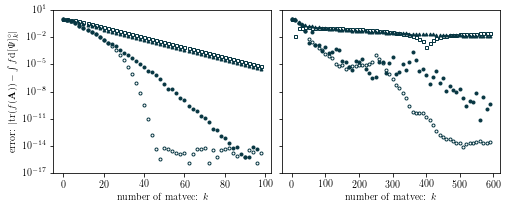

In [5]:
fig,axs = plt.subplots(1,2,figsize=(8,3),sharey=True)
fig.subplots_adjust(wspace=0.05)

for expr_idx,expr in enumerate(exprs):
    
    lam = expr['lam']
    k_max = expr['k_max']
    n = len(lam)
    a,b = min(lam),max(lam)
    
    axs[expr_idx].plot(np.abs(GQ_err[expr_idx])/np.abs(GQ_err[expr_idx])[0],label='GQ',marker='o',ms=3,ls='None',color='#073642')
    axs[expr_idx].plot(np.abs(IQ_err[expr_idx])/np.abs(IQ_err[expr_idx])[0],label='IQ',marker='s',ms=3,ls='None',fillstyle='none',color='#073642')
    axs[expr_idx].plot(np.abs(AQ_err[expr_idx])/np.abs(AQ_err[expr_idx])[0],label='AQ',marker='^',ms=3,ls='None',color='#073642')
    axs[expr_idx].plot(np.abs(GQro_err[expr_idx])/np.abs(GQro_err[expr_idx])[0],label='GQro',marker='o',ms=3,ls='None',fillstyle='none',color='#073642')
   # axs[expr_idx].plot(np.abs(HQ_err[expr_idx]),label='HQ',marker='.')


#axs[0].legend()
axs[0].set_xlabel('number of matvec: $k$')
axs[1].set_xlabel('number of matvec: $k$')
axs[0].set_ylabel(r'error: $|\mathrm{tr}(f(\vec{A}))-\int f \mathrm{d}[\Psi]_k^\circ|$')

axs[0].set_yscale('log')
axs[0].set_ylim(1e-17,1e1)

plt.savefig('imgs/FP_effects.pdf',bbox_inches='tight')